In [246]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли

Загружаем датасет

In [247]:
df = pd.read_csv("C:\IDE\Project_Estate\data.csv")

In [248]:
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


Предварительный анализ данных

In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [250]:
df.isnull().sum().sum()

1869151

In [251]:
import ast
import json
from flatten_json import flatten

Разбираем список json в признаке 'homeFacts'

In [252]:
df['homeFacts'] = df['homeFacts'].apply(lambda a: ast.literal_eval(a))

In [253]:
homeFacts = df['homeFacts'].apply(flatten).apply(pd.Series)

In [254]:
homeFacts = homeFacts.rename(columns = {'atAGlanceFacts_0_factValue' : 'Year built',
                            'atAGlanceFacts_1_factValue' : 'Remodeled year', 
                            'atAGlanceFacts_2_factValue' : 'Heating', 
                            'atAGlanceFacts_3_factValue' : 'Cooling',
                            'atAGlanceFacts_4_factValue' : 'Parking',
                            'atAGlanceFacts_5_factValue' : 'lotsize',
                            'atAGlanceFacts_6_factValue' : 'Price/sqft'})
homeFacts = homeFacts.drop(['atAGlanceFacts_0_factLabel',
                'atAGlanceFacts_1_factLabel',
                'atAGlanceFacts_2_factLabel',
                'atAGlanceFacts_3_factLabel',
                'atAGlanceFacts_4_factLabel',
                'atAGlanceFacts_5_factLabel',
                'atAGlanceFacts_6_factLabel'], axis=1)

Прибавляем дополнительные столбцы которые были зашиты в признаке homeFacts. Удаляем данный признак из датасета

In [255]:
df = pd.concat([df,homeFacts], axis=1)
df = df.drop(['homeFacts'],axis=1)

In [256]:
'''df['schools'] = df['schools'].apply(ast.literal_eval)
schools = pd.json_normalize(
    df['schools'],
    errors='ignore'
)
schools[0].apply(flatten).apply(pd.Series)'''

"df['schools'] = df['schools'].apply(ast.literal_eval)\nschools = pd.json_normalize(\n    df['schools'],\n    errors='ignore'\n)\nschools[0].apply(flatten).apply(pd.Series)"

In [257]:
df.describe()

,status,private pool,propertyType,street,baths,fireplace,city,schools,sqft,zipcode,...,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
count,337267,4181,342452,377183,270847,103115,377151,377185,336608,377185,...,40311,310305,374704,373572,350616,373652,373652,373652,348797,318632
unique,159,1,1280,337076,229,1653,2026,297365,25405,4549,...,2,232944,43939,230,154,1984,1445,3346,37393,6504
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,...,yes,NO MLS,"$225,000",,,,Central,,,
freq,156104,4181,92206,672,52466,50356,24442,4204,11854,2141,...,28793,24,1462,58761,199541,105799,158754,171887,33067,5185


In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 24 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   status          337267 non-null  object
 1   private pool    4181 non-null    object
 2   propertyType    342452 non-null  object
 3   street          377183 non-null  object
 4   baths           270847 non-null  object
 5   fireplace       103115 non-null  object
 6   city            377151 non-null  object
 7   schools         377185 non-null  object
 8   sqft            336608 non-null  object
 9   zipcode         377185 non-null  object
 10  beds            285903 non-null  object
 11  state           377185 non-null  object
 12  stories         226470 non-null  object
 13  mls-id          24942 non-null   object
 14  PrivatePool     40311 non-null   object
 15  MlsId           310305 non-null  object
 16  target          374704 non-null  object
 17  Year built      373572 non-nu

In [790]:
df_new = df.copy()

In [260]:
df_new.head()

,status,private pool,propertyType,street,baths,fireplace,city,schools,sqft,zipcode,...,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,...,NaN,611019,"$418,000",2019,,"Central A/C, Heat Pump",,,None,$144
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,...,NaN,201916904,"$310,000",2019,,,,,5828 sqft,$159/sqft
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,...,yes,FR19221027,"$2,895,000",1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,...,NaN,14191809,"$2,395,000",2006,2006,Forced Air,Central,Detached Garage,"8,220 sqft",$371/sqft
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,...,NaN,861745,"$5,000",,,,,,"10,019 sqft",None


Начинаем работу с признаками по очищению их от повторений, различного написания и прочего.

Укрупняем позиции по признаку propertyType.

In [792]:
def propertyType(arg):
    if arg in ['single-family home', 'Single Family Home', 'Single Family']:
        return 'single-family'
    elif arg in ['Detached, One Story', 'Single Detached, Traditional', '1 Story', 'Single Detached','One Story']:
        return 'cabin'
    elif arg in ['manufactured home (house)', 'mobile', 'prefab', 'modular', 'mo2 le', 'mo2le', 'mobile/manufactured','Mobile / Manufactured','Mfd/Mobile Home']:
        return 'mobile'
    elif arg in ['cabin', 'ca2 n', 'ca2n']:
        return 'cabin'
    elif arg in ['midcentury', 'mid century' ,'mid-century']:
        return 'midcentury'
    elif arg in ['Townhouse', 'townhouse','townhome', 'Townhome']:
        return 'townhouse'
    elif arg in ['Condo', 'condo']:
        return 'condo'
    elif arg in ['Multi-Family Home', 'multi-family', 'Multi Family', 'Multi-Family Home']:
        return 'multi-family'
    elif arg in ['Contemporary', 'Contemporary/Modern', 'Multi Family']:
        return 'contemporary'
    elif arg in ['Land', 'lot/land']:
        return 'lot/land'
    elif arg in ['2 Stories', 'Detached, Two Story','Two Story','2 Story']:
        return '2 Stories'
    else:
        return arg

In [793]:
df_new['propertyType'] = df_new['propertyType'].apply(propertyType)

Оставляем только первые 35 наиболее чато встречающихся значений, остальные кодируем как 'Other'

In [801]:
cols_lst = df_new['propertyType'].value_counts().head(35).index

In [802]:
def proptype_unzip(arg):
    if arg in cols_lst:
        return arg
    else:
        return 'other'

In [803]:
df_new['propertyType'] = df_new['propertyType'].apply(proptype_unzip)

Обрабатываем признак PrivatePool. Объединяем его с дублирующим признаком private pool и удаем его из df.
Там где стоит слово yes - кодируем 1, там где пропуски - ставим 0.

In [266]:
df_new['PrivatePool'].value_counts()

yes    28793
Yes    11518
Name: PrivatePool, dtype: int64

In [804]:
df_new['PrivatePool'] = df_new['PrivatePool'].fillna(df_new['private pool'])
df_new = df_new.drop(['private pool'], axis=1)

In [805]:
df_new['PrivatePool'] = df_new['PrivatePool'].apply(lambda x: 'yes' if x == 'Yes' else x )
df_new['PrivatePool'] = df_new['PrivatePool'].apply(lambda x: 1 if x == 'yes' else 0 )

Разбираем признак baths. Убираем некорректно занесенные данные , там где данные числовые плюс слово Bath, ba и пр оставляем только число. В местах где значения некорректные осталяем значение 0.

In [806]:
def bathnum(arg):
    if type(arg) == str:
        if arg in ['~', 'nan', '—', '--','-- ba','-- Baths', '-- baths', '0', '0 / 0', 'Sq. Ft. ', '0.00', '0.0', 'Sq. Ft.',
                   '1-0 / 1-0 / 1', '1-0 / 1-0 / 1', '3-1 / 2-2', '1 / 1 / 1 / 1', '1 / 1-0 / 1-0 / 1-0',
                   '2-1 / 2-1 / 1-1 / 1-1', 'SemiMod', '116 / 116 / 116','1-2','Bathrooms: SemiMod','1-2 Baths']:
            return 0
        elif arg[-1] == '+':
            return arg[:-1]
        else:
            wrds_list = arg.split()
            if len(wrds_list) == 1:
                return wrds_list[0]
            elif wrds_list[1] in ['ba', 'Baths', 'baths']:
               return wrds_list[0]
            elif wrds_list[0] in ['Bathrooms:']:
                return wrds_list[1]
            else:
                return arg
    elif arg in ['~', 'nan', '—', '--', '0', '0 / 0', 'Sq. Ft. ', '0.00', '0.0', 'Sq. Ft.','SemiMod']:
        return 0
    elif arg in ['1-0 / 1-0 / 1', '1-0 / 1-0 / 1', '3-1 / 2-2', '1 / 1 / 1 / 1', '1 / 1-0 / 1-0 / 1-0', '2-1 / 2-1 / 1-1 / 1-1', 'SemiMod', '116 / 116 / 116','1-2']:
        return 0
    else:   
        return arg

In [807]:
df_new['baths'] = df_new['baths'].apply(bathnum)

In [808]:
df_new['baths'] = df_new['baths'].str.replace(',','.')
df_new['baths'] = df_new['baths'].astype('float')

Разбираем признак sqft. Убираем некорректно занесенные данные , там где данные числовые плюс слово sqft оставляем только число. Числовые значения с ',' преобразуем в числа. В местах где значения некорректные осталяем значение 0.

In [809]:
def sqftres(arg):
    if type(arg) == str:
        wrds_list = arg.split()
        if arg in ['—','--','610-840','610-840 sqft', '-- sqft']:
            return 0        
        elif len(wrds_list) == 1:
            return wrds_list[0]
        elif wrds_list[1] in ['sqft']:
            return wrds_list[0]
        elif wrds_list[-1] == 'sqft':
            return wrds_list[-2]
    else:
        return arg

In [810]:
df_new['sqft'] = df_new['sqft'].apply(sqftres)

In [811]:
df_new['sqft'] = df_new['sqft'].str.replace(',','')
df_new['sqft'] = df_new['sqft'].astype('float')

Разбираем признак fireplace. там где есть хоть какое то упоминание про наличие соотвествующего инвенторя - ставим значение 1. В местах где значений нет осталяем значение 0.

In [812]:
def fireplace(arg):
    if arg in ['Yes', '1', '2', 'Great Room','Fireplace','Gas Logs, Great Room','Living Room', 'Fireplace YN',
               'Fireplace Features','FAMILYRM','1 Fireplace','Gas/Gas Logs', 'Wood Burning',
               'FAMILYRM, Gas Logs', 'Gas Logs, In Great Room', 'Gas Logs','1 Fireplace, Fireplace Living Rm',
               'Wood', 'Special Features', 'Gas Log, One', 'Gas Logs, In Living Room', 'Gas', 'Gas Logs, Living Room',
               'Gas Logs, In Den/Family Room', 'Living Room, Wood Burning', 'One', '1 Fireplace, Fireplace Family Rm',
               'Fireplaces - Woodburning', '# Fireplaces - Gas', 'Log Woodburning, One', 'Electric', 'Family Room',
               'Family Room, Wood Burning', 'In Living Room', 'Gas Fuel,LOCATION', 'Fireplace-Gas, Forced Air','FAMILYRM, Wood Burning',
               '1 Fireplace, Gas Fireplace','Fireplace-Wood, Forced Air', 'Gas, One', 'Gas Vented, Great Room',
               '# Fireplaces - Woodburning','1 Fireplace, Fireplace Family Rm, Gas Fireplace','FAMILYRM, Gas Vented',
               'FAMILYRM, Gas Logs, Gas Vented','Fireplaces', 'Firepit', 'Fire Pit,LOCATION', 'In Living Room, Wood Burning', 'FAMILYRM, Natural Gas',
               'Fire Pit,LOCATION','Gas Fuel','3','4', '5','1 Fireplace, Fireplace Living Rm, Gas Fireplace', 'Gas, Family Room','Great Room, Wood Burning',
               'Gas Logs, Gas Vented, Great Room','Gas Fireplace', 'One, Wood Burning', '1 Fireplace, Fireplace Living Rm, Gas Fireplace', 'In Great Room',
               '1 Fireplace, Wood Burning Frplc','Gas Log Starter, Gas Logs, In Great Room','Wood Burning, Gas Starter','Gas Log' ]:
        return 'yes'
    else:
        return 'no'

In [813]:
df_new['fireplace'] = df_new['fireplace'].apply(fireplace)
df_new['fireplace'] = df_new['fireplace'].apply(lambda x: 1 if x == 'yes' else 0)

Разбираем признак beds. Убираем некорректно занесенные данные , там где данные числовые плюс слово beds оставляем только число. В местах где значения некорректные осталяем значение 0.

In [814]:
def beds(arg):
    if arg in ['--', 'Baths', '1,960 sqft','bd','Beds','Bath','2,178', '2,178 bd','2,178 Beds', 
               '-- bd', '-- Beds','2,178 sqft','8,637','8,637 bd','10,310 bd','Based','Based bd','Based Beds', '1-2', '1-2 bd','1-2 Beds','#',
               '1 Bath, 2 Bedrooms, Living Room, Range/Oven, Refrigerator','1 Bath, 2 Bedrooms',
               "Based on Redfin's St Johns data, we estimate the home's value is $360,731, which is 2.2% less than its current list price.",
               '1 Bath, 2 Bedrooms, Eat-In Kitchen, Living Room, Range/Oven, Refrigerator',
               '3 or More Bedrooms, Dining Room, Living Room, Range/Oven, Refrigerator',
               '1 Bath, 3 or More Bedrooms, Cable TV Available, Dining Room, Eat-In Kitchen, Living Room, Range/Oven, Refrigerator',
               "Based on Redfin's Raleigh data, we estimate the home's value is $708,248, which is 1.2% more than its current list price.",
               '2 Baths, 3 or More Bedrooms','3 or More Bedrooms','1 Bath, 2 Bedrooms, Cable TV Available, Dining Room, Eat-In Kitchen, Living Room',
               '# Bedrooms 1st Floor']:
        return 0
    if type(arg) == str:
        wrds_list = arg.split()
        if len(wrds_list) == 0:
            return 0
        elif len(wrds_list) == 1:
            return wrds_list[0]
        elif (len(wrds_list) > 1) & (wrds_list[1] in ['bd', 'Beds']):
            return wrds_list[0]
        elif wrds_list[-1] in ['acres','sqft', 'Acre','acre','Sqft','Sq.']:
            return 0
        else:
            return arg
    else:
        return arg

In [815]:
df_new['beds'] = df_new['beds'].apply(beds)
df_new['beds'] = df_new['beds'].astype('float')

Разбираем признак stories. Укрупняем группы с некорректно занесенные данные, формируем 5 группы (1,1.5,2,3 эатажа и более). В местах где значения некорректные осталяем значение 0.

In [816]:
def stories(arg):
    if arg in ['1','1.0','1.00','1.0000','1.000','One','One Level', '1 Story', 'One Story', '1 Level','Ranch/1 Story','1 Story/Ranch','1 Story/F.R.O.G.',
               'Ground Level, One','1 Story, Multi Level','1 Story, Hillside','1 Story, Townhouse','1 Story Basement',
               '1 Story, Townhouse',', 1','1 Story, Split Level','1, 1']:
        return 1
    elif arg in ['2.0','2','2.00','Bi-Level','Split Entry (Bi-Level)','2.0000',', 2','2 Stories, Townhouse','2 Story', '2 Story/Basement','2 Stories, Townhouse','2 Stories','Ground Level, Two',
                 'Ground Level, Split Level, Two','Two','2 Levels','2 Stories, Tear Down','2 Story, Tri Level',
                 'Two, Multi/Split','2 Story, Split Level','Double Wide']:
        return 2
    elif arg in ['1.5','1.50','1.5000','1.5 Stories','1.5 Story/Basement', 'One and One Half','1 1/2 Levels',
                 '1 1/2 Story','1.5 Story','1.500']:
        return 1.5
    elif arg in ['3','3.0','3.00','3.000','3.0000','Tri-Level','3 Stories','3+ Story','3 Story, Multi Level','Multi Level, Tri Level',
                 '3 Story','3 Story, Tri Level','3 Levels','Tri Level','Tri/Multi Level','3 Story/Basement','Tri/Multi Level']:
        return 3
    elif arg in ['3+','4.0','Three Or More', '4 Story','3+ Story','6+ Stories','Three Or More Levels',
             '3 - 5 Stories','Multi Level, Three or More','Condo 5+ Stories',]:
        return '3+'
    elif arg in ['0','0.0']:
        return np.nan
    else:
        return arg

In [817]:
def storiesnum(arg):
    if (type(arg) == float) & (type(arg)== int):
        return arg
    elif type(arg) == str:
        if re.search(r'\d+', arg ) is None:
            return 'other'
        else:
            num_st = int(re.search(r'\d+', arg )[0])
            if num_st > 3:
                return '3+'
            elif num_st <= 3:
                return num_st
    else:
        return arg

In [818]:
df_new['stories'] = df_new['stories'].apply(stories)
df_new['stories'] = df_new['stories'].apply(storiesnum)

Год постройки и год последнего ремонта преобразуем в признаки Age возраст постройки и last_repair -  кол-во лет с последнего ремонта

In [819]:
df_new['Year built'] = df_new['Year built'].str.extract('([-+]?\d*\.?\d+)')
df_new['Year built'] = df_new['Year built'].apply(pd.to_numeric)
df_new['Remodeled year'] = df_new['Remodeled year'].str.extract('([-+]?\d*\.?\d+)')
df_new['Remodeled year'] = df_new['Remodeled year'].apply(pd.to_numeric)
df_new = df_new[(df_new['Year built'] > 1787) & (df_new['Year built'] < 2023)]
df_new['Remodeled year']= df_new['Remodeled year'].fillna(0)

In [820]:
df_new['Age'] = 2023 - df_new['Year built']

In [821]:
def last_repair(row):
    if row['Remodeled year'] == 0:
        row['Remodeled year'] = row['Year built']
    return 2023 - row['Remodeled year']

In [822]:
df_new['Repaired'] = df_new['Remodeled year'].apply(lambda x: 1 if x>0 else 0)
df_new['last_repair'] = df_new.apply(lambda row: last_repair(row), axis=1)
df_new = df_new.drop(['Year built','Remodeled year'], axis=1)

Разбираем признак Heating. Укрупняем группы с некорректно занесенные данные, формируем 5 группы (Forced air,Central,Electric,Gas, Heat pump). В местах где значения некорректные оставляем значение 0.

In [823]:
def Heating(arg):
    if arg in ['Forced Air','Forced Air Heating','Hot Air','Forced air, Other','Forced air, Stove','Baseboard, Forced air',
               'Forced air, Wall','Forced Warm Air','Forced air, Radiant','Electric, Forced Air','ForcedAir']:
        return 'Forced air'
    elif arg in ['Central Electric','Central, Electric','Central Electric, Heat Pump','Central Air','Central Furnace','Central Heating','Central Gas','Central Electric, Zoned',
                'Central Air Conditioning','Central Air, Central Heat','Central Air, Ceiling Fan(s)','Central, Gas',
                'Central, Gas, Two or More Units','Central, Heat Pump','Central, Electric, Heat Pump','Central, Natural Gas',
                'Gas Gas','Central Heating, Electric Source','Central, Electric, Two or More Units','Central Electric, Central Gas',
                'Central, Electric, Gas']:
        return 'Central'
    elif arg in ['Electric Heat', 'Electric Hot Air',', Electric Hot Air']:
        return 'Electric'
    elif arg in [', Gas Hot Air/Furnace','Gas Heat','Natural Gas Heat','Gas Hot Air/Furnace','Forced Air, Gas',
                'Forced Air, Natural Gas',', Gas Hot Air/Furnace, MultiZone Heat','Natural Gas',', Gas Hot Air/Furnace, Gas Water Heater',
                'Forced Air - Gas',', Gas Hot Air/Furnace, Natural Gas',', Natural Gas']:
        return 'Gas'
    elif arg in ['Heat Pump','Forced air, Heat pump',', Heat Pump - Heat','Heat Pump(s)','Forced air, Heat pump, Stove',
                'Electric, Heat Pump','Heat pump, Other']:
        return 'Heat pump'
    elif arg in ['No Data']:
        return 
    else:
        return arg

In [824]:
def Heatingtype(arg):
    if arg in ['Forced air', '','Central','Heat pump','Gas', 'Electric']:
        return arg
    else:
        return 'Other'

In [825]:
df_new['Heating'] = df_new['Heating'].apply(Heating)
df_new['Heating'] = df_new['Heating'].apply(Heatingtype)

Разбираем признак Cooling. там где есть хоть какое то упоминание про наличие соотвествующего оборудования - ставим значение 1. В местах где значений нет осталяем значение 0.

In [826]:
def Cooling(arg):
    if arg in ['No Data', '','None']:
        return 0
    else:
        return 1

In [827]:
df_new['Cooling'] = df_new['Cooling'].apply(Cooling)

Разбираем признак Heating. Укрупняем группы с некорректно занесенные данные, формируем 7 групп ('Attached Garage','2 spaces','1 space','Detached Garage', 'Carport','3 spaces','Off Street'). В местах где значения некорректные оставляем значение 0.

In [828]:
def Parking(arg):
    if arg in ['2']:
        return '2 spaces'
    elif arg in ['Off Street, Attached Garage','Attached - REAR','Attached Garage, Garage - 2 Car',
                 'Garage Attached','Attached - SIDE, AGGRE','2 Car Garage, Attached Garage, Opener',
                'Attached Garage, Driveway','Attached - FRONT','Attached Garage, Driveway, Garage - 2 Car']:
        return 'Attached Garage'
    elif arg in ['1']:
        return '1 space'
    elif arg in ['Carport, Attached Garage','Attached Garage, Carport','Carport, Detached Garage',
                'Off Street, Carport','Carport Spaces']:
        return 'Carport'
    elif arg in ['Off street','Off street parking']:
        return 'Off Street'
    elif arg in ['Detached Garage, Attached Garage']:
        return 'Attached Garage, Detached Garage'
    elif arg in ['3']:
        return '3 spaces'
    elif arg in ['4']:
        return '4 spaces'
    elif arg in ['No Data','None','0']:
        return None
    else:
        return arg

In [829]:
def Parkingnum(arg):
    if arg in ['Attached Garage', '','2 spaces','1 space','Detached Garage', 'Carport','3 spaces','Off Street']:
        return arg
    else:
        return 'Other'

In [830]:
df_new['Parking'] = df_new['Parking'].apply(Parking)
df_new['Parking'] = df_new['Parking'].apply(Parkingnum)

Разбираем признак lotsize. Некорректно занесенным данным присваиваем 0. Остальные значения преобразуем ',' заменяя на пустоту. Перевоим признак в число, с учетом того, что есть значения в акрах - умножаем его на 43560 для перевода в квадратные футы 

In [831]:
def lotsize(arg):
    if arg in ['2', '2 spaces']:
        return None
    elif arg in ['No Data','—','-- sqft lot']:
        return None
    else:
        return arg

In [832]:
df_new['lotsize'] = df_new['lotsize'].apply(lotsize)

In [833]:
df_new['lotsize'] = df_new['lotsize'].str.replace(',','')

In [834]:
def lotsizesqft(arg):
    if arg == '':
        return None
    if type(arg) == str:
        wrds_list = arg.split()
        if len(wrds_list) == 1:
            return arg
        elif wrds_list[1] in ['acres','Acres','acre','Acre']:
            return 43560*float(wrds_list[0])
        elif wrds_list[1] in ['sqft','Sq.']:
            return wrds_list[0]
        else:
            return arg
    else:
        return arg

In [835]:
df_new['lotsize'] = df_new['lotsize'].apply(lotsizesqft)
df_new['lotsize'] = df_new['lotsize'].astype('float')

Разбираем признак status. Укрупняем группы с некорректно занесенные данные.

In [836]:
def status(arg):
    if arg in ['For sale']:
        return 'for sale'
    elif arg in ['Pre-foreclosure / auction']:
        return 'Pre-foreclosure'
    elif arg in ['Under Contract   Showing','Under Contract','Active Under Contract']:
        return 'Under Contract Show'
    elif arg in [' / auction']:
        return 'Auction'
    elif arg in ['Foreclosed','Foreclosure']:
        return 'foreclosure'
    elif arg in ['A Active']:
        return 'Active'
    else:
        return arg

In [837]:
df_new['status'] = df_new['status'].apply(status)

Разбираем признак target. Переводим $ в числовой признак.

In [838]:
def target(arg):
    if type(arg) == str:
        if (arg[0] == '$') & (arg[-1] == '+'):
            return arg[1:-1]
        elif (arg[0] == '$') & (arg[-3:] == '/mo'):
            return 0
        elif arg[0] == '$':
            return arg[1:]
        elif arg[-1] == '+':
            return arg[:-1]
        elif arg[-3:] == '/mo':
            return 0
        else:
            return arg
    else:
        return arg

In [839]:
df_new['target'] = df_new['target'].str.replace(',','')
df_new.target = df_new.target.apply(target)
df_new.target = df_new.target.astype('float')

In [840]:
df_new = df_new.reset_index(drop=True)
df_new = df_new.drop_duplicates()
df_new = df_new.drop(index=df_new[df_new['lotsize'] < 0].index[0], axis=0)

In [841]:
df_new_1 = df_new.copy()

Разбираем признак MlsId. Убираем некорректные данные, дополняем признак дублирующимся mls-id, 

In [842]:
def MlsId(arg):
  if arg in ['NO MLS', 'No MLS #', ' A, Houston, TX 77008', 'No ',
       ' 12A, Orlando, FL 32833', ' B, Houston, TX 77008', 'No mls',
       ' 1, South Boston, MA 02127', ' 11A, Orlando, FL 32833',
       ' B, Houston, TX 77007', ' 2, Washington, DC 20002',
       ' 1, Washington, DC 20002', ' 2, Washington, DC 20010', '2101941',
       ' 3A, Orlando, FL 32833', ' 2, Washington, DC 20009',
       'No MLS', ' 0, Doral, FL 33178', ' 1, Washington, DC 20001',
       ' A, Austin, TX 78721', ' 1A, Orlando, FL 32833', 'NOMLSID',
       ' A, Austin, TX 78704', ' 2, Boston, MA 02129',
       ' 2, Washington, DC 20001', ' 1, Washington, DC 20010',
       ' A, Houston, TX 77018', ' A, Houston, TX 77057', ' 1, Washington, DC 20009',
       ' C, Houston, TX 77007',' 0, Medley, FL 33178',' 1, Austin, TX 78702',' 2, Orlando, FL 32835',
       ' 4, Washington, DC 20009',' 2, Washington, DC 20011',' B, Houston, TX 77054',' B, Houston, TX 77018',
       ' D, Houston, TX 77008',' 1, Boston, MA 02125',' 601, Fort Lauderdale, FL 33304',' B, Austin, TX 78721',
       ' 2, Orlando, FL 32822',' A, Austin, TX 78702',' B, Houston, TX 77057',' A, Austin, TX 78723',
       ' C, Houston, TX 77008',' A, Seattle, WA 98103', '1539721',' B, Austin, TX 78704',' B, Austin, TX 78751']:
       return 'NO MLS'
  else:
    return arg

In [ ]:
df_new_1['MlsId'] = df_new_1['MlsId'].fillna(df_new_1['mls-id'])

In [843]:
df_new_1['MlsId'] = df_new_1['MlsId'].apply(MlsId)

В признаке город - 1830 значений, оставляем только перые 100 наиболее часто встречающиеся в датасете, остальные заполняем признаком 'other'

In [845]:
city_list = list(df_new_1['city'].value_counts().head(100).index)

In [846]:
def citynum(arg):
    if arg in city_list:
        return arg
    else:
        return 'other'

In [847]:
df_new_1['city'] = df_new_1['city'].apply(citynum)

В признаке возраст здания и последний год ремонта - есть неточности, есть значения где время прошедшее с ремонта больше возраста дома. Предполагаем, это ошибка ручного ввода, менем их местами.

In [ ]:
def reversage(row1,row2):
    if row2 > row1:
        return row2
    else:
        return row1

Очищаем данные. Оставляем только данные с ванными комнатами и спальнями менее 20, берем только строки где определена целевая переменная "target", не берем значения где не определен город в котором находится недвиимость. Убираем дубликаты с одинковыми индексами, адресами и MlsId.

In [848]:
df_new_1 = df_new_1[df_new_1['baths'] < 20]
df_new_1 = df_new_1[df_new_1['beds'] < 20]
df_new_1 = df_new_1[~df_new_1.target.isnull()]
df_new_1['Age'] = df_new_1.apply(lambda x: reversage(x['Age'], x['last_repair']), axis=1)
df_new_1 = df_new_1[df_new_1['city'].isnull() != True]
df_new_1 = df_new_1[~df_new_1.duplicated(['MlsId', 'zipcode','street'])]

In [849]:
df_new_1.shape

(220707, 24)

In [482]:
df_new_1.head()

,status,propertyType,street,baths,fireplace,city,schools,sqft,zipcode,beds,...,MlsId,target,Heating,Cooling,Parking,lotsize,Price/sqft,Age,Repaired,last_repair
0,Active,single-family,240 Heather Ln,3.5,1,other,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900.0,28387,4.0,...,611019,418000.0,Other,0,,NaN,$144,4.0,0,4.0
1,for sale,single-family,12911 E Heroy Ave,3.0,0,other,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",1947.0,99216,3.0,...,201916904,310000.0,,0,,5828.0,$159/sqft,4.0,0,4.0
2,for sale,single-family,2005 Westridge Rd,2.0,0,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...",3000.0,90049,3.0,...,FR19221027,2895000.0,Forced air,1,Attached Garage,8626.0,$965/sqft,62.0,1,56.0
3,for sale,single-family,4311 Livingston Ave,8.0,0,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...",6457.0,75205,5.0,...,14191809,2395000.0,Forced air,1,Detached Garage,8220.0,$371/sqft,17.0,1,17.0
7,Active,single-family,11182 Owl Ave,2.0,0,other,"[{'rating': ['2', '2', '4', '7', '4', 'NR'], '...",3588.0,50401,3.0,...,190988,244900.0,Forced air,1,,124582.0,$68,53.0,0,53.0


Удаляем ненужные признаки, проводим анализ, дохаполняем пропуски.

In [850]:
df_new_1 = df_new_1.drop(['street','schools','zipcode','Price/sqft','mls-id','MlsId','lotsize'], axis=1)

In [767]:
df_new_1.describe().T

,count,mean,std,min,25%,50%,75%,max
baths,220707.0,2.716005,1.299218e+00,0.75,2.0,2.0,3.0,1.900000e+01
fireplace,220707.0,0.144907,3.520079e-01,0.00,0.0,0.0,0.0,1.000000e+00
sqft,218436.0,6095.671785,1.703117e+06,0.00,1350.0,1864.0,2635.0,7.959794e+08
beds,220707.0,3.147694,1.477935e+00,0.00,2.0,3.0,4.0,1.900000e+01
PrivatePool,220707.0,0.153656,3.606197e-01,0.00,0.0,0.0,0.0,1.000000e+00
target,220707.0,669233.681061,1.762630e+06,0.00,219900.0,349000.0,610000.0,1.950000e+08
Cooling,220707.0,0.762590,4.254964e-01,0.00,1.0,1.0,1.0,1.000000e+00
lotsize,172817.0,105776.286265,7.454928e+06,1.00,5053.0,7840.0,12632.4,2.147484e+09
Age,220707.0,41.408872,3.291662e+01,1.00,16.0,35.0,63.0,2.850000e+02
Repaired,220707.0,0.448382,4.973295e-01,0.00,0.0,0.0,1.0,1.000000e+00


In [851]:
df_new_1['stories'] = df_new_1['stories'].fillna('')
df_new_1['status'] = df_new_1['status'].fillna('')
df_new_1.stories = df_new_1.stories.astype('str')

In [852]:
df_new_1.describe(include='object').T

,count,unique,top,freq
status,220707,131,for sale,130960
propertyType,220707,35,single-family,141048
city,220707,100,other,64495
state,220707,34,FL,65219
stories,220707,7,1,69727
Heating,220707,7,Forced air,108050
Parking,220707,9,Attached Garage,58517


In [855]:
df_new_1.shape

(220707, 17)

Осставляем в признаки status только первые 7 наиболее часто встречающихся

In [856]:
def stutusnum(arg):
    if arg in ['for sale','Active','Pending','Under Contract Show','New construction','Auction','Contingent']:
        return arg
    else:
        return 'other'

In [857]:
df_new_1['status'] = df_new_1['status'].apply(stutusnum)

In [858]:
df_new_1[df_new_1['status'] == 'other'].shape

(40174, 17)

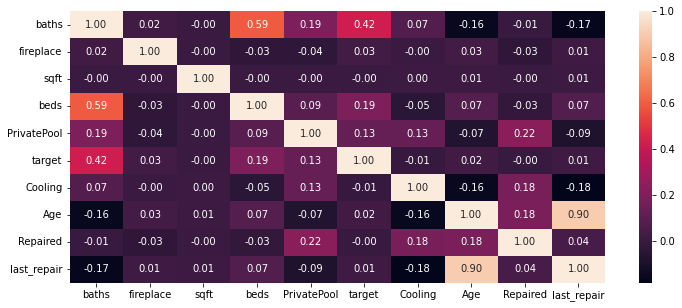

In [575]:
#строим тепловую карту корреляций
fig = plt.figure(figsize=(12, 5))
sns.heatmap(df_new_1.corr(), annot=True, fmt=".2f");

Для числовых признаков проверяем выбросы по методу 3 сигма. 

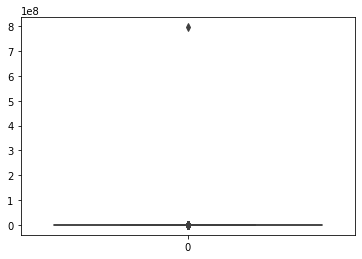

In [206]:
sns.boxplot(data=df_new_1['sqft']);

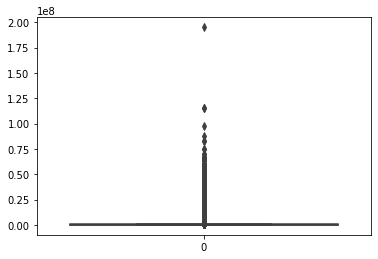

In [166]:
sns.boxplot(data=df_new_1['target']);

In [885]:
#Объявляем функцию, реализующую фильтрацию выбросов по методу z-отклонений
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned
#Производим очистку 
outliers, df_new_1_cleaned = outliers_z_score(df_new_1, 'sqft', True)
outliers, df_new_1_cleaned = outliers_z_score(df_new_1_cleaned, 'target', True)
outliers

,status,propertyType,baths,fireplace,city,sqft,beds,state,stories,PrivatePool,target,Heating,Cooling,Parking,Age,Repaired,last_repair
367,for sale,single-family,9.0,0,Fort Lauderdale,10330.0,7.0,FL,3,1,24000000.0,Forced air,1,Attached Garage,7.0,1,6.0
467,other,single-family,3.5,0,Chicago,3300.0,4.0,IL,,0,0.0,Central,0,Other,110.0,0,110.0
519,other,multi-family,2.0,0,Boston,1673.0,2.0,MA,,0,0.0,,0,,38.0,0,38.0
566,for sale,condo,6.0,0,Chicago,7587.0,4.0,IL,3+,1,15174000.0,Forced air,1,Attached Garage,4.0,0,4.0
1010,other,condo,7.0,0,Miami,8360.0,5.0,FL,,1,12250000.0,Other,1,Other,4.0,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312097,for sale,condo,10.0,0,New York,3330.0,4.0,NY,,1,14950000.0,,0,,5.0,0,5.0
312692,for sale,condo,5.0,0,New York,5874.0,4.0,NY,3+,0,14995000.0,Forced air,0,,8.0,0,8.0
312815,other,single-family,2.0,0,Detroit,1258.0,4.0,MI,,0,1000.0,Forced air,0,Attached Garage,95.0,0,95.0
313341,other,condo,3.0,0,Miami Beach,4379.0,3.0,FL,,0,8900000.0,Forced air,1,Off Street,20.0,0,20.0


In [777]:
df_new_1_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
baths,215197.0,2.693100,1.233978,0.75,2.0,2.0,3.0,19.0
fireplace,215197.0,0.145959,0.353066,0.00,0.0,0.0,0.0,1.0
sqft,215197.0,2174.820262,1257.817430,248.00,1350.0,1860.0,2616.0,14370.0
beds,215197.0,3.134876,1.456511,0.00,2.0,3.0,4.0,19.0
PrivatePool,215197.0,0.153004,0.359992,0.00,0.0,0.0,0.0,1.0
target,215197.0,569876.115894,755820.073299,16000.00,219999.0,348900.0,599900.0,8490000.0
Cooling,215197.0,0.768705,0.421662,0.00,1.0,1.0,1.0,1.0
Age,215197.0,41.083068,32.571719,1.00,16.0,34.0,62.0,235.0
Repaired,215197.0,0.456010,0.498062,0.00,0.0,0.0,1.0,1.0
last_repair,215197.0,36.784611,30.436998,1.00,14.0,28.0,53.0,235.0


In [886]:
outliers, df_new_1_cleaned = outliers_z_score(df_new_1_cleaned, 'sqft', True)
outliers, df_new_1_cleaned = outliers_z_score(df_new_1_cleaned, 'target', True)
outliers, df_new_1_cleaned = outliers_z_score(df_new_1_cleaned, 'Age')
outliers, df_new_1_cleaned = outliers_z_score(df_new_1_cleaned, 'last_repair')
outliers, df_new_1_cleaned = outliers_z_score(df_new_1_cleaned, 'baths')
outliers.shape

(2231, 17)

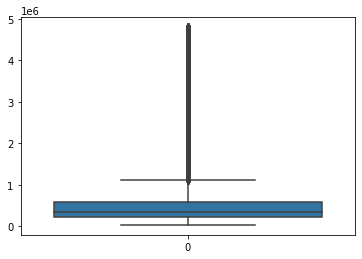

In [887]:
sns.boxplot(data=df_new_1_cleaned['target']);

In [726]:
df_new_1_cleaned.shape

(202555, 17)

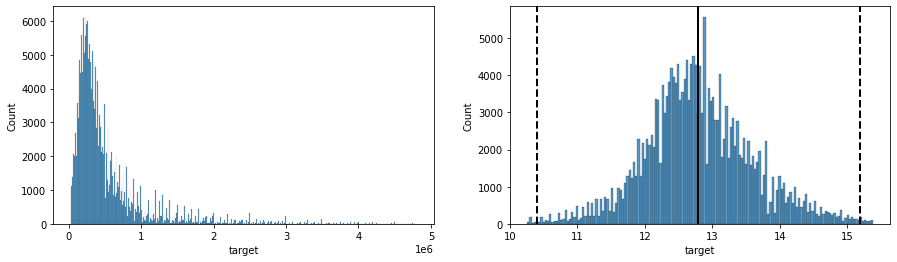

In [888]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
sns.histplot(data=df_new_1_cleaned, x='target', ax=axes[0]);
#Логарифмируем
log_price = np.log(df_new_1_cleaned['target'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_price, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_price.mean(), color='k', lw=2)
axes[1].axvline(log_price.mean()+ 3 *log_price.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_price.mean()- 3 *log_price.std(),
                color='k', ls='--', lw=2);

Строим корреляцию числовых признаков уже для очищенных данных

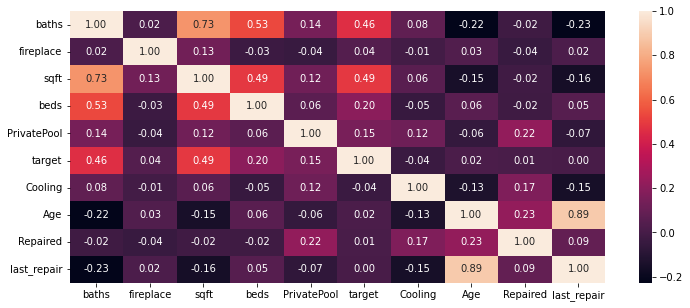

In [889]:
#строим тепловую карту корреляций
fig = plt.figure(figsize=(12, 5))
sns.heatmap(df_new_1_cleaned.corr(), annot=True, fmt=".2f");

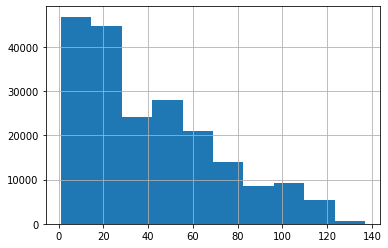

In [884]:
df_new_1_cleaned['Age'].hist();

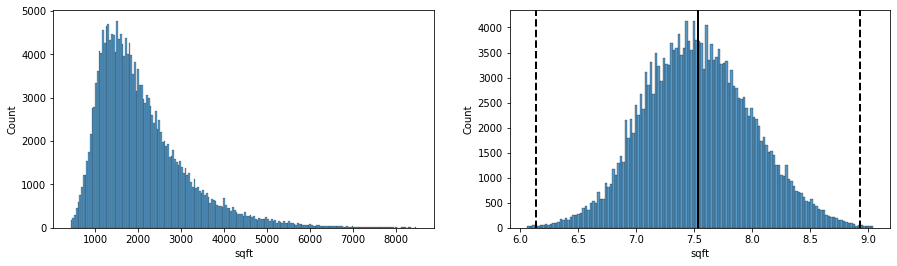

In [890]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
sns.histplot(data=df_new_1_cleaned, x='sqft', ax=axes[0]);
#Логарифмируем
log_price = np.log(df_new_1_cleaned['sqft'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_price, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_price.mean(), color='k', lw=2)
axes[1].axvline(log_price.mean()+ 3 *log_price.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_price.mean()- 3 *log_price.std(),
                color='k', ls='--', lw=2);

Видем сильную корреляцию между возрастом постройки и кол-вом лет с последнего проведенного ремонта. Удаляем один из признаков

In [891]:
df_new_1_cleaned = df_new_1_cleaned.drop(['last_repair'],axis=1)

In [699]:
##df_new_1_cleaned['sqft'] = np.log(df_new_1_cleaned['sqft'])
##df_new_1_cleaned['target'] = np.log(df_new_1_cleaned['target'])

Кодируем категориальные признаки методом OneHotEncoder

In [409]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders.binary import BinaryEncoder

label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder()
bn_encoder = BinaryEncoder()

In [924]:
categorical_features_one = ['status','city','propertyType','stories','Heating','Parking','state']
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
data_onehot = onehot_encoder.fit_transform(df_new_1_cleaned[categorical_features_one]).toarray() 
column_names = onehot_encoder.get_feature_names(categorical_features_one)
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
dummies_data = pd.merge(df_new_1_cleaned, data_onehot, left_index=True, right_index=True)
dummies_data = dummies_data.drop(categorical_features_one, axis=1)

c:\Users\Дмитрий\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [911]:
#Производим кодирование категориальных признаков
dummies_data.head()

,baths,fireplace,sqft,beds,PrivatePool,target,Cooling,Age,Repaired,status_Active,...,state_OR,state_PA,state_SC,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI
0,3.5,1,2900.0,4.0,0,418000.0,0,4.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,0,1947.0,3.0,0,310000.0,0,4.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.0,0,3000.0,3.0,1,2895000.0,1,62.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.0,0,3588.0,3.0,0,244900.0,1,53.0,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3.0,0,1930.0,3.0,0,311995.0,1,4.0,0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [912]:
dummies_data.isnull().sum().sum()

0

Опрееляем целевую переменную 'target'. Делем выборку на train test в соотношении 80/20

In [894]:
#X - матрица наблюдений, y - столбец правильных ответов
X = dummies_data.drop('target', axis=1)
y = dummies_data['target']

In [895]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=40 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (166608, 208)
Test shape: (41653, 208)


Вводим функцию для определения метрик регрессии 

In [868]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('Train RMSE: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict))))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))
    print('Test RMSE: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict))))

Обучаем модель линейной регресии как наиболее простую для сравнения метрик с этой моделью

In [896]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.571
Train MAE: 207303.155
Train MAPE: 56.877
Train RMSE: 350965.244


Test R^2: 0.576
Test MAE: 205710.310
Test MAPE: 57.051
Test RMSE: 345378.652


Делаем аналогичное обучение модели линейной регресс с примененнием Minmax scale. Результат почти идентичный, отличается слабо.

In [853]:
from sklearn.preprocessing import MinMaxScaler

In [882]:
#Создаем объект для min-max нормализации
scaler = MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Инициализируем объект класса линейная регрессия
sgd_lr = linear_model.SGDRegressor(random_state=42)
#Обучаем модель - ищем параметры
sgd_lr.fit(X_train_scaled, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = sgd_lr.predict(X_train_scaled)
y_test_pred = sgd_lr.predict(X_test_scaled)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.583
Train MAE: 156231.668
Train MAPE: 47.860
Train RMSE: 242585.559


Test R^2: 0.588
Test MAE: 157023.972
Test MAPE: 48.439
Test RMSE: 242623.181


Делаем аналогичное обучение модели линейной регресс предварительно переведя целевой признак в логарифмическую шкулу. Результат так же почти не отличается от обычной регрессии.

In [881]:
#создаем логарифмированный целевой признак цены
y_train_log = np.log(y_train)
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель предсказывать логарифм целевого признака
lr.fit(X_train, y_train_log)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train_pred = np.exp(lr.predict(X_train))
y_test_pred = np.exp(lr.predict(X_test))
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.545
Train MAE: 143421.409
Train MAPE: 35.299
Train RMSE: 253540.702


Test R^2: 0.546
Test MAE: 144183.136
Test MAPE: 35.548
Test RMSE: 254793.395


Обучаем модель и строим предсказание с помощью RandomForestRegressor. Результат значительно улучшается

In [93]:
from sklearn.ensemble import RandomForestRegressor

In [907]:
regr = RandomForestRegressor(n_estimators=150, max_depth=25,min_samples_leaf=2, random_state=0)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, min_samples_leaf=2, n_estimators=150,
                      random_state=0)

In [908]:
#Делаем предсказание для каждой из выборок
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.902
Train MAE: 95545.749
Train MAPE: 27.626
Train RMSE: 167571.963


Test R^2: 0.737
Test MAE: 142434.956
Test MAPE: 35.201
Test RMSE: 271962.962


Подбираем оптимальны параметры для модели RandomForestRegressor. Находим лучшее предсказания с помощью данного метода.

In [96]:
from sklearn.model_selection import RandomizedSearchCV

In [909]:
param_distributions = {'n_estimators': list(range(100, 400, 30)),
              'min_samples_leaf': [2,7],
              'max_depth': list(np.linspace(5, 25, 5, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10,
    scoring='neg_root_mean_squared_error',
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
y_test_pred = random_search_forest.predict(X_test)
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

KeyboardInterrupt: 

c:\Users\Дмитрий\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:1009: RuntimeWarning: invalid value encountered in divide
  y_hat /= len(self.estimators_)
c:\Users\Дмитрий\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:1009: RuntimeWarning: invalid value encountered in divide
  y_hat /= len(self.estimators_)


ValueError: Input contains NaN.

In [554]:
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

Наилучшие значения гиперпараметров: {'n_estimators': 130, 'min_samples_leaf': 2, 'max_depth': 25}


In [592]:
regr_best = RandomForestRegressor(**random_search_forest.best_params_)
regr_best.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = regr_best.predict(X_train)
y_test_pred = regr_best.predict(X_test)

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.852
Train MAE: 94428.715
Train MAPE: 31.869
Train RMSE: 144635.952


Test R^2: 0.700
Test MAE: 125972.603
Test MAPE: 37.919
Test RMSE: 207174.504


Обучаем модель CatBoostRegressor. Находим лучшее предсказания с помощью данного метода.

In [594]:
from catboost import CatBoostRegressor

In [897]:
model_cat = CatBoostRegressor(iterations=10000, learning_rate=0.1) 
model_cat.fit( 
	X_train, y_train, 
	eval_set=(X_test, y_test), 
) 

0:	learn: 513512.0251385	test: 508182.0896502	best: 508182.0896502 (0)	total: 33.4ms	remaining: 5m 34s
1:	learn: 494521.5812982	test: 488965.8294134	best: 488965.8294134 (1)	total: 61.2ms	remaining: 5m 6s
2:	learn: 478706.3606832	test: 472957.8381177	best: 472957.8381177 (2)	total: 88.8ms	remaining: 4m 55s
3:	learn: 464319.6536828	test: 458241.2962112	best: 458241.2962112 (3)	total: 114ms	remaining: 4m 45s
4:	learn: 452538.5300289	test: 446346.6591193	best: 446346.6591193 (4)	total: 144ms	remaining: 4m 46s
5:	learn: 441784.1351155	test: 435561.4889114	best: 435561.4889114 (5)	total: 171ms	remaining: 4m 44s
6:	learn: 432673.4621980	test: 426442.5825570	best: 426442.5825570 (6)	total: 197ms	remaining: 4m 41s
7:	learn: 424925.4357034	test: 418528.1194232	best: 418528.1194232 (7)	total: 223ms	remaining: 4m 37s
8:	learn: 418457.8697051	test: 412097.1563326	best: 412097.1563326 (8)	total: 258ms	remaining: 4m 46s
9:	learn: 412148.0957229	test: 405659.0646211	best: 405659.0646211 (9)	total: 29

In [898]:
#Делаем предсказание для каждой из выборок
y_train_pred = model_cat.predict(X_train)
y_test_pred = model_cat.predict(X_test)

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.881
Train MAE: 104398.888
Train MAPE: 25.877
Train RMSE: 184479.432


Test R^2: 0.767
Test MAE: 132593.533
Test MAPE: 30.114
Test RMSE: 255861.526


Смотрим параметры модели которые в наибольшей степени влияют на результат.

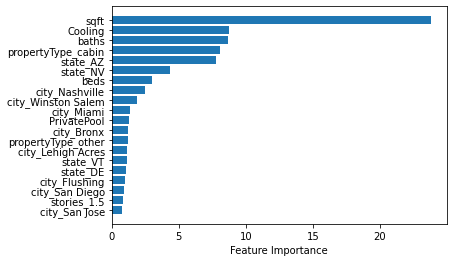

In [900]:
sorted_feature_importance = model_cat.get_feature_importance().argsort( 
	)[-20:] 
plt.barh( 
	dummies_data.columns[sorted_feature_importance], 
	model_cat.feature_importances_[sorted_feature_importance] 
) 
plt.xlabel("Feature Importance") 
plt.show()

Смотрим разброс ошибки, пытаемся улучшить предсказание. Проанализировав выпадающие значения.

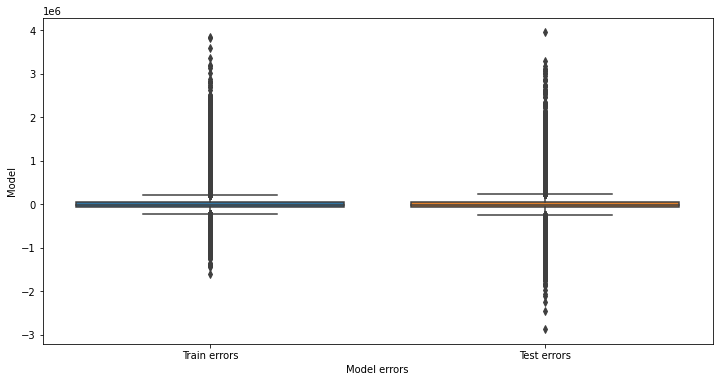

In [901]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура+координатная плоскость
#Ошибки модели на тренировочной выборке 
y_train_errors = y_train - y_train_pred
#Ошибки модели на тестовой выборке
y_test_errors = y_test - y_test_pred
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

In [902]:
y_train_errors = pd.DataFrame({'Train errors': y_train_errors})
y_test_errors = pd.DataFrame({'Test errors': y_test_errors})

In [903]:
predict_df_Train = pd.concat([X_train, y_train_errors], axis=1)
predict_df_Test = pd.concat([X_test, y_test_errors], axis=1)

In [904]:
outliers_er_t, predict_df_error = outliers_z_score(predict_df_Test, 'Test errors')
er_t = outliers_er_t.sort_values('Test errors',ascending=0).head(10).index

In [905]:
outliers_er_t.sort_values('Test errors',ascending=0).head(10)

,baths,fireplace,sqft,beds,PrivatePool,Cooling,Age,Repaired,status_Active,status_Auction,...,Parking_,Parking_1 space,Parking_2 spaces,Parking_3 spaces,Parking_Attached Garage,Parking_Carport,Parking_Detached Garage,Parking_Off Street,Parking_Other,Test errors
54067,2.00,1,2280.0,3.0,0,1,62.0,1,0,0,...,0,0,1,0,0,0,0,0,0,3.945317e+06
236177,6.00,0,7557.0,5.0,1,1,18.0,1,0,0,...,0,0,0,0,1,0,0,0,0,3.292435e+06
293250,5.00,0,5110.0,4.0,1,1,15.0,1,0,0,...,0,0,0,0,1,0,0,0,0,3.164540e+06
263179,2.00,0,2080.0,3.0,0,1,68.0,1,0,0,...,0,0,0,0,0,0,1,0,0,3.111035e+06
259473,3.00,0,2199.0,4.0,0,1,23.0,1,0,0,...,0,0,0,0,1,0,0,0,0,3.103182e+06
107227,2.00,0,1584.0,3.0,0,1,17.0,1,0,0,...,0,0,0,0,1,0,0,0,0,3.067041e+06
149412,3.00,0,1440.0,3.0,0,0,83.0,1,0,0,...,0,0,0,0,1,0,0,0,0,3.057683e+06
57588,2.25,1,3304.0,0.0,0,1,15.0,1,1,0,...,1,0,0,0,0,0,0,0,0,3.002505e+06
97164,3.00,1,4850.0,3.0,0,0,8.0,0,1,0,...,1,0,0,0,0,0,0,0,0,2.996155e+06
73144,4.50,0,6710.0,5.0,0,1,12.0,0,1,0,...,0,0,0,0,0,0,0,0,1,2.942927e+06


In [906]:
df_new_1.loc[er_t]

,status,propertyType,baths,fireplace,city,sqft,beds,state,stories,PrivatePool,target,Heating,Cooling,Parking,Age,Repaired,last_repair
54067,for sale,single-family,2.00,1,Austin,2280.0,3.0,TX,1,0,4500000.0,Forced air,1,2 spaces,62.0,1,62.0
236177,for sale,single-family,6.00,0,Jacksonville,7557.0,5.0,FL,2,1,4700000.0,Heat pump,1,Attached Garage,18.0,1,18.0
293250,for sale,single-family,5.00,0,other,5110.0,4.0,FL,,1,4500000.0,Forced air,1,Attached Garage,15.0,1,15.0
263179,for sale,single-family,2.00,0,Indianapolis,2080.0,3.0,IN,,0,3300000.0,Other,1,Detached Garage,68.0,1,68.0
259473,for sale,single-family,3.00,0,Indianapolis,2199.0,4.0,IN,,0,3300000.0,Other,1,Attached Garage,23.0,1,23.0
107227,for sale,single-family,2.00,0,Indianapolis,1584.0,3.0,IN,,0,3300000.0,Forced air,1,Attached Garage,17.0,1,17.0
149412,for sale,single-family,3.00,0,Indianapolis,1440.0,3.0,IN,,0,3300000.0,Other,0,Attached Garage,83.0,1,53.0
57588,Active,other,2.25,1,Seattle,3304.0,0.0,WA,,0,4700000.0,Other,1,,15.0,1,15.0
97164,Active,single-family,3.00,1,other,4850.0,3.0,WA,,0,4800000.0,,0,,8.0,0,8.0
73144,Active,single-family,4.50,0,other,6710.0,5.0,MD,3,0,4200000.0,Forced air,1,Other,12.0,0,12.0


Сереализуем лучшую модель и метод OneHotEncoder для последующей реализации предсказания через запрос на сервере

In [879]:
import pickle

In [880]:
with open('Estate_cat.pkl', 'wb') as output:
    pickle.dump(model_cat, output)

In [ ]:
with open('Estate_rf.pkl', 'wb') as output:
    pickle.dump(regr_best, output)

In [913]:
with open('one_hot_enc.pkl', 'wb') as output:
    pickle.dump(onehot_encoder, output)